In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from function_utils import display_circles
import gc

In [2]:
sns.set_palette("Pastel2")

In [3]:
df = pd.read_csv("datasets/data_segmentation_rfm.csv")
df.set_index("customer_unique_id", inplace=True)
df.head(3)

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19
0000f46a3911fa3c0805444483337064,586,1,86.22


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96095 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        96095 non-null  int64  
 1   Frequency      96095 non-null  int64  
 2   MonetaryValue  96095 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.9+ MB


# Préparation des données

In [5]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(df['Recency'])
customers["Frequency"] = np.log1p(df["Frequency"])
customers["MonetaryValue"] =np.log1p(df["MonetaryValue"])
customers.tail()

,Recency,Frequency,MonetaryValue
customer_unique_id,,,
fffcf5a5ff07b0908bd4e2dbc735a684,6.208590,0.693147,7.634540
fffea47cd6d3cc0a88bd621562a9d061,5.743003,0.693147,4.449452
ffff371b4d645b6ecea244b27531430a,6.428105,0.693147,4.731450
ffff5962728ec6157033ef9805bacc48,5.135798,0.693147,4.902976
ffffd2657e2aad2907e67c3e9daecbeb,6.280396,0.693147,4.284414


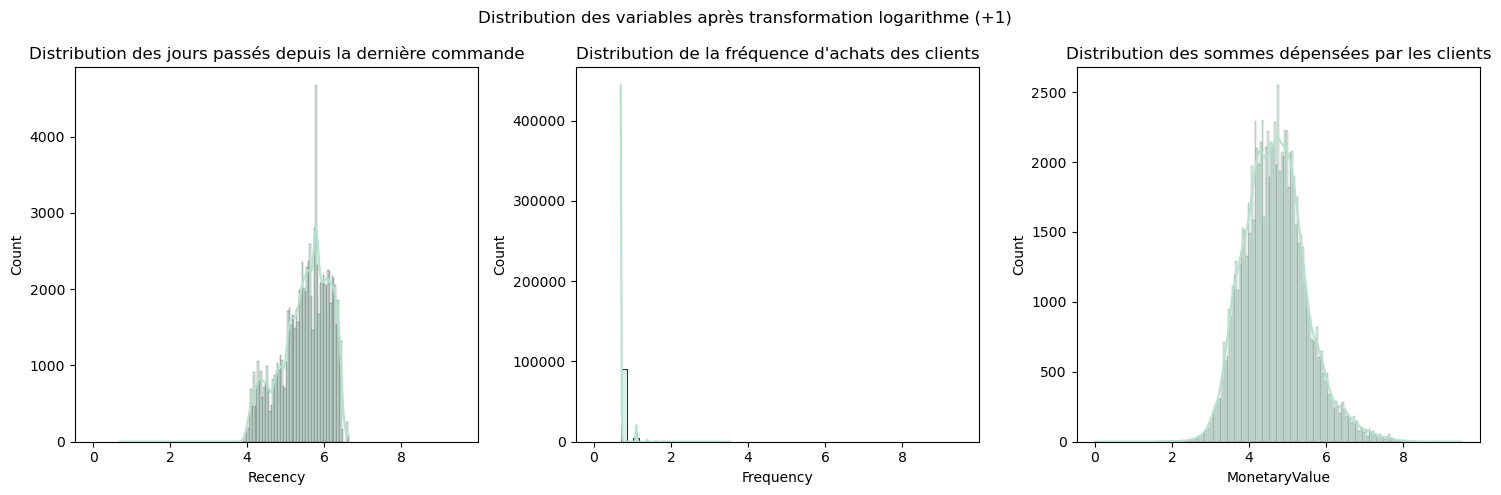

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Distribution des variables après transformation logarithme (+1)')

sns.histplot(ax=axes[0],x="Recency", data=customers, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.histplot(ax=axes[1],x="Frequency", data=customers, kde=True)
axes[1].set_title("Distribution de la fréquence d'achats des clients")

sns.histplot(ax=axes[2],x="MonetaryValue", data=customers, kde=True)
axes[2].set_title("Distribution des sommes dépensées par les clients")

plt.tight_layout()
plt.show();

- Standardisation

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(customers)
customers_normalized = scaler.transform(customers)

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [ 0.  0. -0.]
Standard Deviation: [1. 1. 1.]


# Réduction de dimensions

In [8]:
from sklearn.decomposition import PCA

n_comp = 2
pca = PCA(n_components = n_comp)
features = customers.columns
data_pca = pca.fit_transform(customers_normalized)
pcs = pca.components_

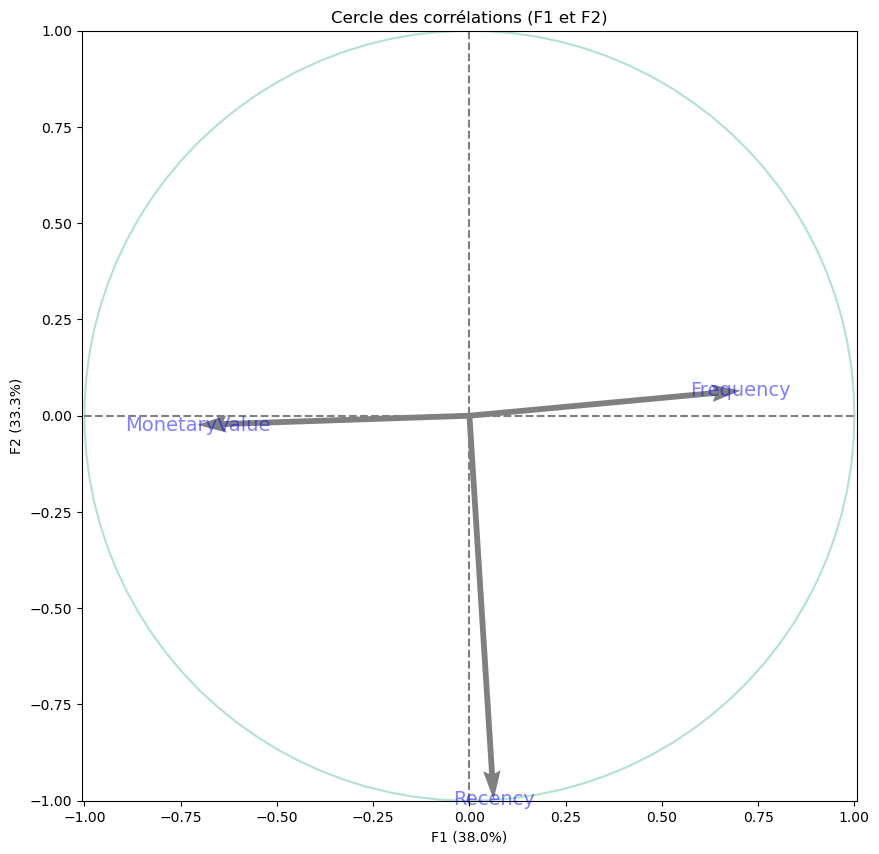

In [9]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Modélisation

## K-Means

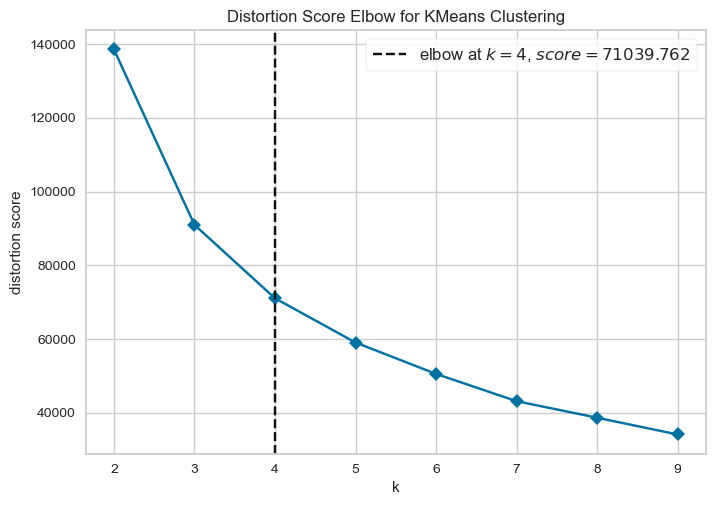

In [10]:
# Elbow method pour déterminer le nombre de clusters optimale
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k =(2, 10), timings=False)
visualizer.fit(data_pca)
visualizer.show();

In [11]:
sns.set_palette("Pastel2")

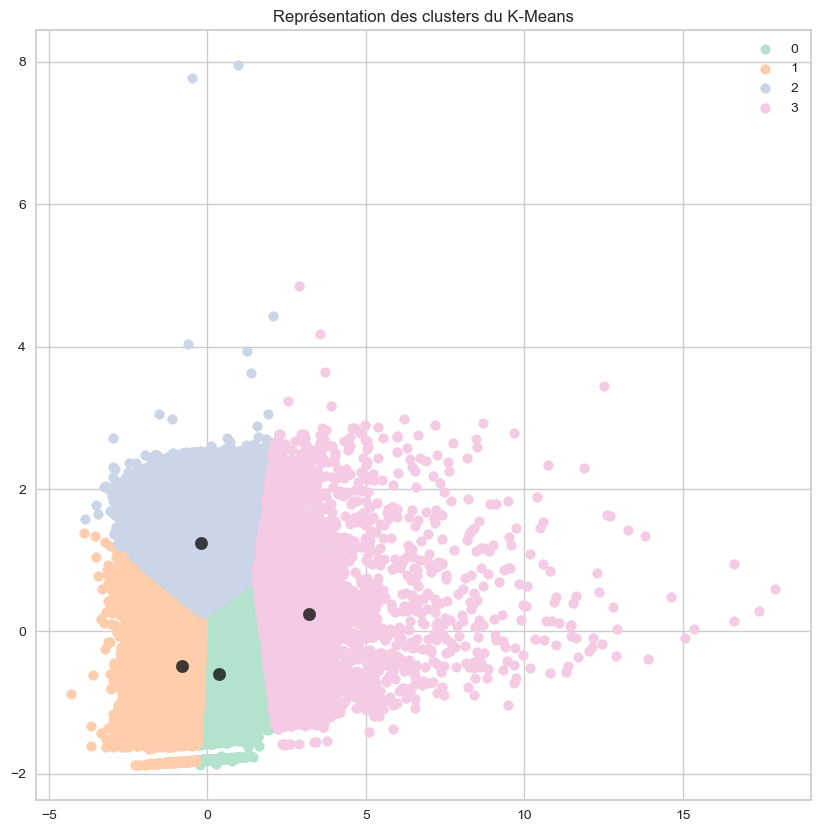

In [12]:
# Calcul du K-Means et affectation du cluster à chaque bâtiment
km = KMeans(n_clusters=4)

#Prédiction
label = km.fit_predict(data_pca)
 
centroids = km.cluster_centers_
u_labels = np.unique(label)

#Représentation graphique:
plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(data_pca[label == i , 0] , data_pca[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
#plt.savefig("Présentation/Images/representation_kmeans.png")
plt.show();

### Description des clusters obtenus avec le modèle

In [13]:
df["Cluster"] = km.labels_
df.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean"}).round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,375.84,1.02,72.66
1,342.53,1.00,301.56
2,119.30,1.01,143.65
3,289.72,2.44,70.48


In [14]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = df.index
df_normalized["Cluster"] = km.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars = ["Recency", "Frequency", "MonetaryValue"],
                      var_name = "Attribute",
                      value_name = "Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,2,Recency,-0.671915
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,Recency,-0.642163
2,0000f46a3911fa3c0805444483337064,0,Recency,1.415528
3,0000f6ccb0745a6a4b88665a16c9f078,0,Recency,0.671591
4,0004aac84e0df4da2b147fca70cf8255,1,Recency,0.520547


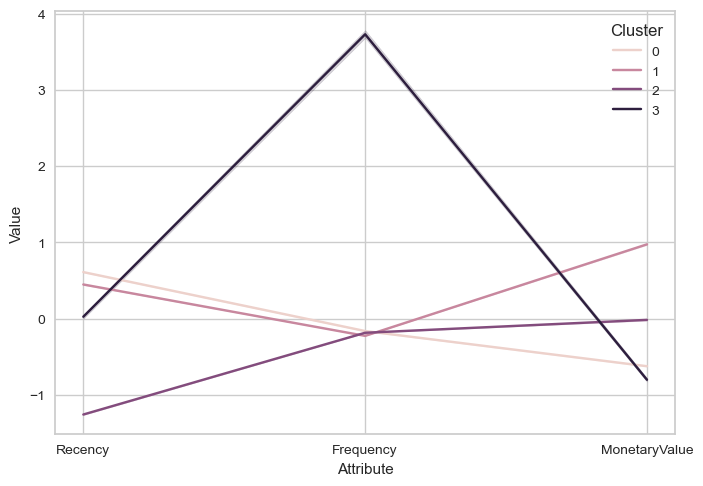

In [15]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.show()

### Evaluation du modèle

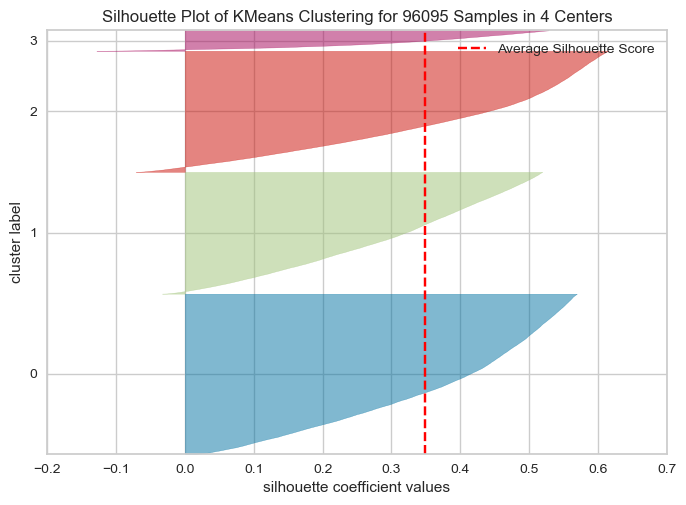

In [16]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

visualizer.fit(data_pca)        # Fit the data to the visualizer
visualizer.show();              # Finalize and render the figure

In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score:", silhouette_score(data_pca, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(data_pca, label))

Silhouette Score: 0.34885996789018775
Score de Davies-Bouldin: 0.9190068495922968


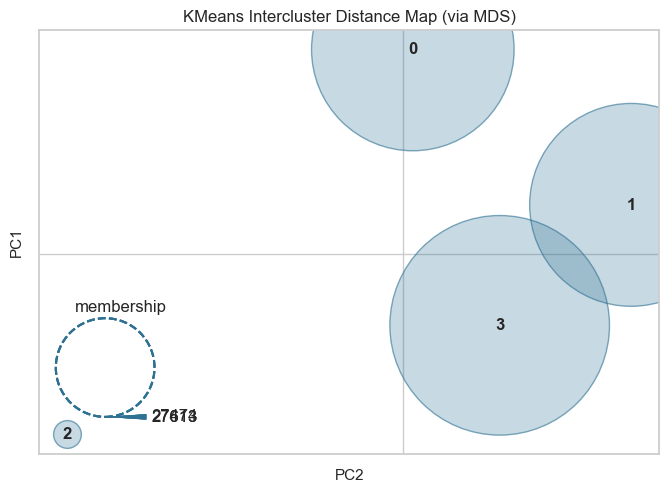

In [18]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4, random_state=42), data_pca);

## K-Prototype

https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

In [31]:
from kmodes.kprototypes import KPrototypes

In [32]:
data = pd.read_csv("datasets/data_clustering_complete.csv")
data.set_index("customer_unique_id", inplace=True)
data.head()

,customer_city,Recency,Frequency,MonetaryValue,distance_customer_seller,product_category_name,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,161,1,141.90,109.119060,bed_bath_table,6.0,10.0,5
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,164,1,27.19,22.813939,health_beauty,2.0,7.0,4
0000f46a3911fa3c0805444483337064,sao jose,586,1,86.22,516.989962,stationery,25.0,27.0,3
0000f6ccb0745a6a4b88665a16c9f078,belem,370,1,43.62,2479.718229,telephony,20.0,31.0,4
0004aac84e0df4da2b147fca70cf8255,sorocaba,337,1,196.89,153.807837,telephony,13.0,20.0,5


In [33]:
cols = data.columns

for col in cols:
    if data[col].dtypes =="float":
        data[col] = np.log1p(data[col].values)

In [34]:
data_test_30d = data.loc[data["Recency"] < 30]
data_test_60d = data.loc[data["Recency"] < 60]
data_test_90d = data.loc[data["Recency"] < 90]
data_test_120d = data.loc[data["Recency"] < 120]
data_test_150d = data.loc[data["Recency"] < 150]
data_test_180d = data.loc[data["Recency"] < 180]

In [35]:
data.head()

,customer_city,Recency,Frequency,MonetaryValue,distance_customer_seller,product_category_name,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,cajamar,161,1,4.962145,4.701562,bed_bath_table,1.945910,2.397895,5
0000b849f77a49e4a4ce2b2a4ca5be3f,osasco,164,1,3.338967,3.170271,health_beauty,1.098612,2.079442,4
0000f46a3911fa3c0805444483337064,sao jose,586,1,4.468434,6.249956,stationery,3.258097,3.332205,3
0000f6ccb0745a6a4b88665a16c9f078,belem,370,1,3.798182,7.816303,telephony,3.044522,3.465736,4
0004aac84e0df4da2b147fca70cf8255,sorocaba,337,1,5.287711,5.042185,telephony,2.639057,3.044522,5


In [39]:
cat_var = ["review_score", "customer_city", "product_category_name"]
num_var = ["Frequency", "nb_days_before_delivered", "nb_days_before_delivered_estimation", 
           "MonetaryValue", "distance_customer_seller"]

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median", fill_value="missing")),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
    ('cat', cat_pipe, cat_var),
    ('num', num_pipe, num_var)
])

In [42]:
data_normalized = preprocessor.fit_transform(data)
data_normalized = pd.DataFrame(data_normalized, columns=["review_score", "customer_city", "product_category_name",
                                                         "Frequency","nb_days_before_delivered", 
                                                         "nb_days_before_delivered_estimation","MonetaryValue", 
                                                         "distance_customer_seller"])

In [43]:
for col in num_var:
    data_normalized[col] = data_normalized[col].astype("float32")

In [44]:
catColumnsPos = [data_normalized.columns.get_loc(col) for col in list(data_normalized.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(data_normalized.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['review_score', 'customer_city', 'product_category_name']
Categorical columns position  : [0, 1, 2]


In [45]:
dfMatrix = data_normalized.to_numpy()
dfMatrix

array([[3, 'sao jose', 'stationery', ..., 0.5393354892730713,
        -0.24896495044231415, 0.3142307996749878],
       [4, 'belem', 'telephony', ..., 0.95468670129776,
        -1.079232096672058, 1.484610676765442],
       [5, 'sorocaba', 'telephony', ..., -0.3555034101009369,
        0.765906810760498, -0.5882197022438049],
       ...,
       [4, 'feira de santana', 'baby', ..., 1.0504024028778076,
        -0.27247875928878784, 1.1212420463562012],
       [5, 'sinop', 'auto', ..., 2.015143394470215, 0.07684426754713058,
        1.1213140487670898],
       [5, 'campo largo', 'perfumery', ..., -0.0725344866514206,
        -0.47691765427589417, 0.03548689931631088]], dtype=object)

In [46]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 42)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([2, 0, 0, ..., 2, 2, 0], dtype=uint16)

In [47]:
kprototype.cluster_centroids_

array([['-0.1736164093017578', '-0.08149633553926323',
        '0.014708357899686383', '-0.3940398847853121',
        '0.17087419899397052', '5', 'sao paulo', 'bed_bath_table'],
       ['2.82594396123072', '0.16187714637354675', '0.2314438884668961',
        '-0.5764343866993419', '0.2024178876030796', '5', 'sao paulo',
        'bed_bath_table'],
       ['-0.15590943822804948', '0.7291691046242128',
        '0.6958334072426572', '0.7575000278991156', '0.6397574687241372',
        '5', 'rio de janeiro', 'bed_bath_table'],
       ['-0.09257083162339445', '-1.20970967546503',
        '-1.403837706480576', '-0.2824787035366133',
        '-1.6745529908868222', '5', 'sao paulo', 'health_beauty']],
      dtype='<U32')

In [48]:
data['cluster_id'] = kprototype.labels_

In [49]:
clustering_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", kprototype)
])

### Analyse du clustering

In [52]:
data["review_score"] = data["review_score"].astype("int32")

In [54]:
for col in cols:
    if data[col].dtypes =="float":
        data[col] = np.expm1(data[col].values)

In [55]:
data.groupby('cluster_id').agg({
    'Frequency' : "mean",
    'MonetaryValue': "mean",
    'distance_customer_seller' : "mean",
    'nb_days_before_delivered' : "mean",
    'nb_days_before_delivered_estimation' : "mean",
    'review_score':"mean"}).round(2)

,Frequency,MonetaryValue,distance_customer_seller,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score
cluster_id,,,,,,
0,1.00,89.89,527.93,10.88,23.12,4.21
1,2.43,90.23,657.06,13.41,25.21,4.00
2,1.01,266.02,1028.77,19.69,29.34,3.80
3,1.04,124.73,56.06,5.04,14.49,4.29


### Evaluation de la stabilité

- Diagramme de Sankey pour évaluer les flux (mensuels, bi-mensuels, trimestres)

In [68]:
data_test_180d_tr = preprocessor.transform(data_test_180d)
data_test_180d_tr = pd.DataFrame(data_test_180d_tr, columns=["review_score", "customer_city", "product_category_name",
                                                           "Frequency","nb_days_before_delivered", 
                                                           "nb_days_before_delivered_estimation","MonetaryValue", 
                                                           "distance_customer_seller"])

In [70]:
dataMatrix_180d = data_test_180d_tr.to_numpy()

In [72]:
labels_180 = kprototype.predict(dataMatrix_180d, categorical=catColumnsPos)

from sklearn.metrics import adjusted_rand_score

print("ARI :", adjusted_rand_score(train_data['cluster_id'].values,labels_30))